# Qutrit上でToffoli Gateを作る

Toffoli gateは様々なQuantum algorithmで必須なゲートですが、Qubit上のゲートに分解しようとすると少なくとも6個のtwo-qubit (CNOT) gateが必要になり、主要なエラー源になっています。そこで|0>,|1>基底のみを利用するQubitではなく、|2>基底も加えたQutritを考えると下図のように3個のtwo-qubit(CNOT) gateのみで済むことが分かります。気になる点として2つのsingle-qutrit($X_{12}$) gateが新しく出現しています。現状ではsingle-qutrit gateのエラー率はsingle-qubit gateよりは高くtwo-qubit gateよりは低いため、6個のCNOT gateが必要なqubit上でのtoffoliに対して優位性があると期待できます。
<br>
<br>
Qutrit上でのtoffoliの分解方法もいくつか存在し、下図が最適な分解方法かもわかりません。ただ現時点では下図が最も効率的な分解方法だと思います。現時点でのIBMのHardwareでは$X_{02}$ gateが使えず、$X_{12}$ gateのみをQiskit Pulseを通して利用できるため、この分解方法を採用しています。Hardwareの発展によって最適な分解方法は変わっていくと思います。

![a](mini_toffoli.png) 

しかしこのままでは一つ問題があります。IBMで提供されているデフォルトのCNOTは制御ビットが|2>の状態の時に標的ビット上でRabi振動を起こしてしまうことが実験的に確認され、その理由もHamiltonianレベルで分かっています。そのため制御ビットが|2>の時は標的ビットの状態を変化させないようなPure CNOTを改めて実装する必要があります。この辺りの詳しい話は3節で説明します。逆にPure CNOTである必要があるのは真ん中のCNOTのみであり、それを挟む2つのCNOTは必ずしもpure CNOTである必要はありません。（標的ビットが|2>である場合は特に影響がないことがわかっています。）

## Contents

このnotebookでやりたいことは、まず上図のtoffoliをpulse scheduleで実装し、IBMの実機で回してみることです。流れとしてはまず各ゲートをpulse levelで表現します。ただしX gateとCNOT gateはIBM側でCalibrationされたDefaultのものを利用します。$X_{12}$ gateだけは自分でCalibrationします。Pulse levelでゲート構築が出来たら、それらをPulse schedule上で並べていき、最後に測定を行います。今季は初期状態を|000>とするので、観測される状態も|000>に近いほど嬉しいです。Qubit上のToffoliの結果と比べることをこのnotebookの目標とします。

1. [Calibration of $X_{01}$ gate](#a)
2. [Calibration of $X_{12}$ gate](#b)
3. [Imprement Pure CNOT gate](#c)
4. [Pulse Schedule](#d)
5. [New Toffoli on Qutrits vs Old Toffoli on Qubits](#e)    

なお今回で使う実機はibmq_torontoです。OpenPulseに対応している実機ではなんでも良いはずです。またibmq_torontoの0,1,2の量子ビットを今回は用います。上図のtoffoliとしての対応関係は制御1->0,制御2->1,標的->2とします。

## 事前設定

In [1]:
from qiskit import *
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo',group='internal',project='icepp')
#provider.backends(simulator=False)

In [2]:
backend = provider.get_backend('ibmq_toronto')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
sys.path.append('..')

from lmfit.models import SineModel, PolynomialModel

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform
from qiskit.pulse import ShiftPhase,Play,Drag,GaussianSquare,DriveChannel,ControlChannel
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from qiskit.visualization import plot_histogram

In [4]:
# 使うQubitのindex
ctr_q1 = 14
ctr_q2 = 11
tar_q = 8

# 実験のショット回数
NUM_SHOTS = 8192

#（各デバイスに固有の）データをスケーリング。sydneyはe-7でした。
scale_factor = 1e-7

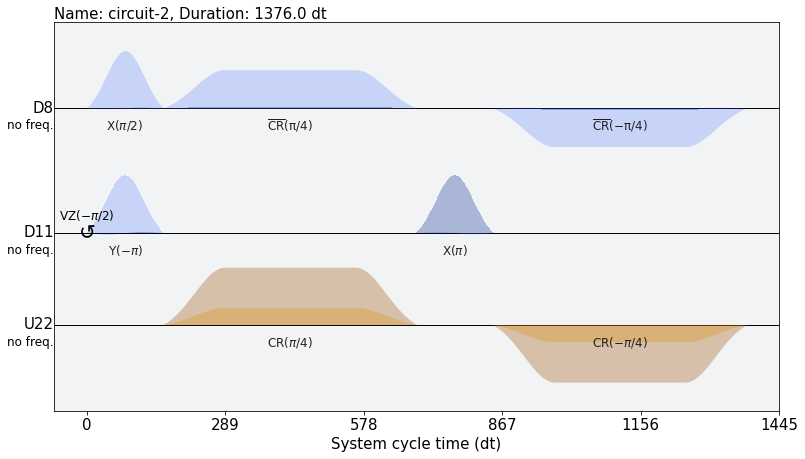

In [5]:
qc_cx01 = QuantumCircuit(2)
qc_cx01.cx(0,1)

transpiled_qc_cx01 = transpile(qc_cx01, backend, initial_layout = [ctr_q2, tar_q])
sched_cx01 = schedule(transpiled_qc_cx01, backend)

sched_cx01.draw()

In [202]:
from calibration import x01,x12,pure_cnot

## 1. Calibration of $X_{01}$ gate <a id="a"></a>

In [19]:
test = x01.sweep(qubit=ctr_q2, shots=8192, backend=backend, scale_factor=1e-7)

In [20]:
x01_freq_sweep_data, x01_sweep_freqs = test.freq(amp=0.1, freq_med=None)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run


[ 4.72795696e+08  5.11640493e+09  2.35592563e+07 -5.09515801e+00] [-6.13724426e+06  5.11633685e+09  2.23980919e+07 -7.15426736e+00]


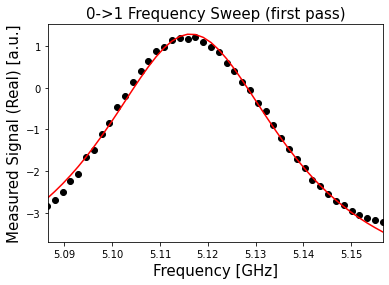

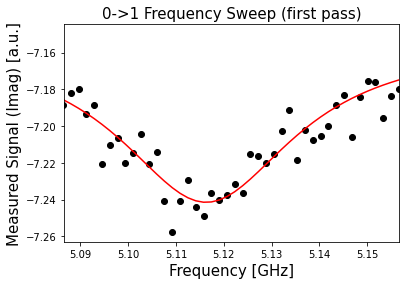

In [21]:
x01_freq_real, x01_freq_imag = test.fitting_freq(x01_freq_sweep_data, x01_sweep_freqs,
                                                 parameters_real=[1e8, test.default_qubit_freq, 1e7, -2],
                                                 parameters_imag=[-1e6, test.default_qubit_freq, 1e7, -2])

In [22]:
x01_freq_real, x01_freq_imag

(5116404932.250774, 5116336852.725153)

In [23]:
x01_amp_data, drive_amps = test.amp(x01_freq_real, amp_med=None)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run


[-3.24999616 -0.12297815  0.31817961 -0.02282242] [-6.68984720e-03 -7.18637224e+00  2.74467745e-01  4.25245300e-01]


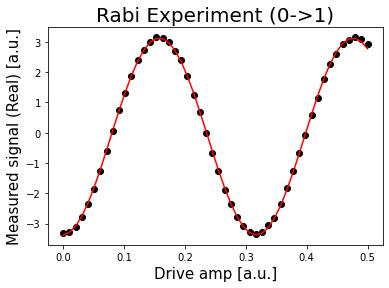

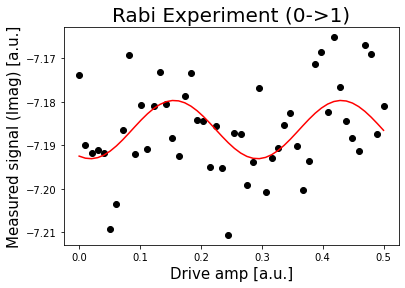

In [24]:
x01_amp_real, x01_amp_imag = test.fitting_amp(x01_amp_data, drive_amps,
                                                  parameters_real=[1, 0, 0.3, 1],
                                                  parameters_imag=[-0.1, -3, 0.3, 1])

In [25]:
x01_amp_real, x01_amp_imag

(0.15908980465627, 0.13723387238697907)

In [26]:
pi_pulse_01 = test.calibrated_x01(x01_amp_real)

In [27]:
IQ_01_data = test.check(pi_pulse_01, x01_freq_real)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run


In [28]:
LDA_01 = test.discriminator(IQ_01_data)

0.9901123046875


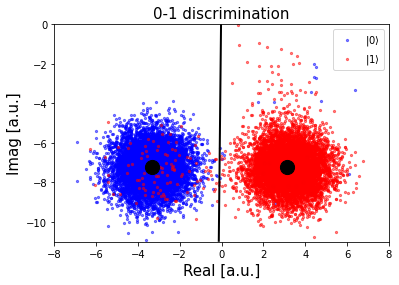

In [33]:
(x_min,x_max,y_min,y_max)=(-8,8,-11,0)
test.IQ_01_plot(IQ_01_data, x_min, x_max, y_min, y_max)
test.separatrixPlot(LDA_01, x_min, x_max, y_min, y_max)

## 2. Calibration of $X_{12}$ gate <a id="b"></a>

初めに|1>と|2>間のエネルギー差に該当するマイクロ波パルスの振動数$f_{12}$を測定します。そのためにはまず量子ビットを|1>の状態に励起させる必要があるので$X_{01}$ gateを作用させます。その後に一定の振動数範囲をスイープして$f_{12}$を探索します。IBMQでは$f_{12}<f_{01}$であるので$X_{01}$ gateのdefault周波数よりも低い範囲をスイープしていきます。

In [34]:
test = x12.sweep(qubit=ctr_q2, shots=8192, backend=backend, scale_factor=1e-7,
                 x01_freq=x01_freq_real, x01_amp=x01_amp_real)

基本的にはfreq_medはNoneのままにしても大丈夫ですが、実際実験してみるとたまにズレていることがあるのでその時は自分で設定します。

In [35]:
x12_freq_sweep_data, x12_sweep_freqs = test.freq(amp=0.2, freq_med=None)
#x12_freq_sweep_data, x12_sweep_freqs = test.freq(amp=0.2, freq_med=4.715e9)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run


[7.32141295e+07 4.78273497e+09 1.80916548e+07 2.89902946e+00] [ 2.23486547e+08  4.78273055e+09  1.81029996e+07 -7.75341799e+00]


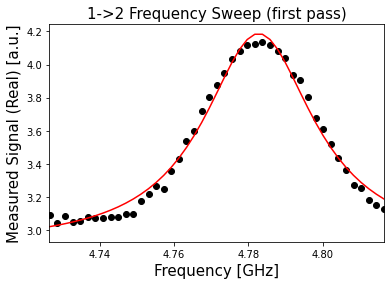

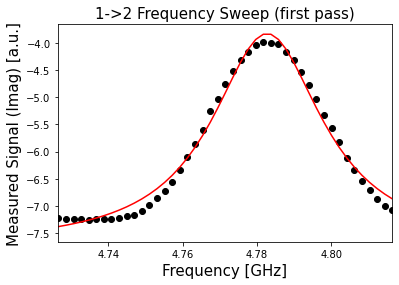

In [36]:
x12_freq_real, x12_freq_imag = test.fitting_freq(x12_freq_sweep_data, x12_sweep_freqs,
                                              parameters_real=[5e7, test.default_qubit_freq-3.4e8, 1e7, 3],
                                              parameters_imag=[1e8, test.default_qubit_freq -3.4e8, 1e7, -2])

In [37]:
x12_freq_real, x12_freq_imag

(4782734972.917239, 4782730554.797027)

In [38]:
x12_data, x12_drive_amps = test.amp(x12_freq_imag, amp_med=None)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run


[-0.58164218  3.64068552  0.49994957 -0.03917293] [-1.77517945 -5.4756606   0.50216727 -0.04442894]


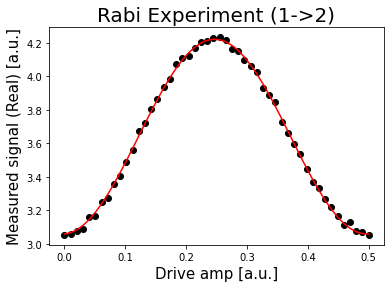

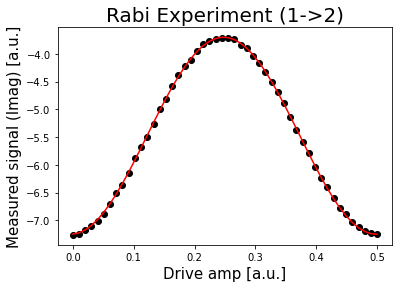

In [39]:
x12_amp_real, x12_amp_imag = test.fitting_amp(x12_data, x12_drive_amps,
                                                  parameters_real=[1, 0.4, 0.5, 1],
                                                  parameters_imag=[2, 0.5, 0.5, 1])

In [40]:
x12_amp_real, x12_amp_imag

(0.24997478745588786, 0.2510836361430759)

In [41]:
pi_pulse_12 = test.calibrated_x12(x12_freq_imag, x12_amp_imag)
pi_pulse_12_reverse = test.calibrated_x12(x12_freq_imag, -x12_amp_imag)

In [42]:
IQ_12_data = test.check(pi_pulse_12)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run


In [43]:
LDA_12 = test.discriminator(IQ_12_data)

0.9646809895833334


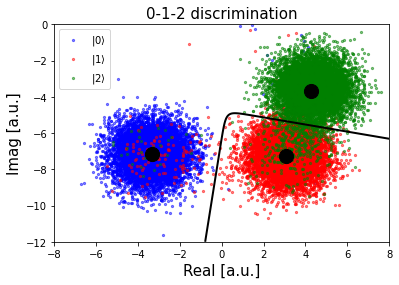

In [49]:
(x_min,x_max,y_min,y_max)=(-8,8,-12,0)
test.IQ_012_plot(IQ_12_data, x_min, x_max, y_min, y_max)
test.separatrixPlot(LDA_12, x_min, x_max, y_min, y_max)

### 前日にCalibrationした値を用いる場合

In [7]:
x01_freq_real = 5116404932.250774
x01_amp_real  = 0.15908980465627
x12_freq_imag = 4782730554.797027
x12_amp_imag  = 0.2510836361430759

In [203]:
#moduleを更新したい時
import importlib
importlib.reload(pure_cnot)
test = pure_cnot.sweep(qubits=[ctr_q1,ctr_q2,tar_q], shots=8192, backend=backend, scale_factor=1e-7, 
                       x01_freq=x01_freq_real, x01_amp=x01_amp_real, x12_freq=x12_freq_imag, x12_amp=x12_amp_imag)

## 3. Imprement Pure CNOT <a id="c"></a>

IBMでは電場で制御ビットを"標的ビットのdrive frequency"とdrive amplitudeでドライブすると、標的ビットが|0>と|1>間でラビ振動を起こす"Cross Resonace"を利用してCNOTを実装しています。echoの形を使わなければ、ラビ振動数は制御ビットの状態が|0>, |1>, |2>のどの状態であるかによって異なります。しかしCNOTは制御ビットが|1>の時だけ標的ビットを反転させることでした。これをラビ振動で表現するためには制御ビットの状態が|0> or |2>である場合は標的ビットの状態が元々の状態に戻り、制御ビットの状態が|1>である場合は標的ビットの状態が反転していれば良いわけです。つまり制御ビットが|0>もしくは|2>の時はラビ振動の周期がπずれるような電場のdrive frequencyとdrive amplitude、durationをsweep法で探せばよいことを指しています。
<br>
<br>
この条件を満たす変数の組み合わせは多くあり、本来は全ての組み合わせを探索するべきですが、ここではそこそこの値を探索する戦略を用います。LBNLのグループが出しているアイデアですが、電場のFrequencyを固定しAmplitudeの一次元sweepを行うことで、制御ビットの状態が|0>と|2>の時のRabi振動数が一致するAmplitudeの組み合わせを割り出します。その後pure CNOTになる瞬間のパルス時間をsweepで探索します。

In [204]:
test = pure_cnot.sweep(qubits=[ctr_q1,ctr_q2,tar_q], shots=8192, backend=backend, scale_factor=1e-7, 
                       x01_freq=x01_freq_real, x01_amp=x01_amp_real, x12_freq=x12_freq_imag, x12_amp=x12_amp_imag)

In [9]:
# 実験の構成
num_points = 50 # 実験数（つまり掃引する振幅）
#num_points = 75 # 実験数（つまり掃引する振幅）

# 駆動時間の繰り返し値：均等に配置された75個のduration。16の倍数でなければならない。
drive_duration_min = 16*5
drive_duration_max = 16*348
#drive_duration_max = 16*153
drive_durations = np.linspace(drive_duration_min, drive_duration_max, num_points, dtype='int')

In [10]:
drive_durations

array([  80,  192,  304,  416,  528,  640,  752,  864,  976, 1088, 1200,
       1312, 1424, 1536, 1648, 1760, 1872, 1984, 2096, 2208, 2320, 2432,
       2544, 2656, 2768, 2880, 2992, 3104, 3216, 3328, 3440, 3552, 3664,
       3776, 3888, 4000, 4112, 4224, 4336, 4448, 4560, 4672, 4784, 4896,
       5008, 5120, 5232, 5344, 5456, 5568])

まず制御ビットの状態が|0>の時と|2>の時のRabi振動が一致する電場のamplitudeを探ります。

In [11]:
new_cx = test.new_cnot(rx_angle=0)

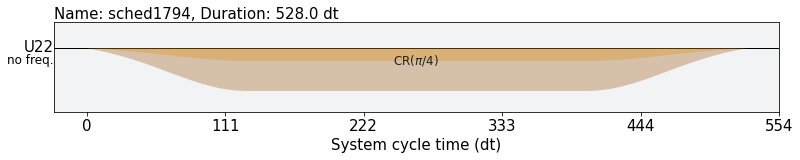

In [12]:
new_cx.draw()

In [13]:
amp_list = [1.0,1.2,1.6,2.0,2.4]
#amp_list=[1]

In [14]:
data0_list, data2_list = test.rabi02(amp_list, drive_durations=drive_durations, new_cx=new_cx)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [64]:
#test.duration_graph(data0_list[0], drive_durations, ylim=[-2,2])

In [15]:
freq0_list, freq2_list = test.rabi02freq(data0_list=data0_list, data2_list=data2_list, drive_durations=drive_durations)

In [16]:
freq0_list, freq2_list

([1616.5638786305315,
  1473.089019072016,
  1348.7978799024227,
  1377.0412237416563,
  1413.0857874157841],
 [5267.3161195562325,
  5360.287446424284,
  1685.8274882164226,
  1344.866491960725,
  920.7838541320393])

交点の座標は(Drive Power,Rabi Period)=( 0.6018213276803549 , 1347.1625177485537 )
defaultのdrive powerに 1.9355810540047493 倍すればOK


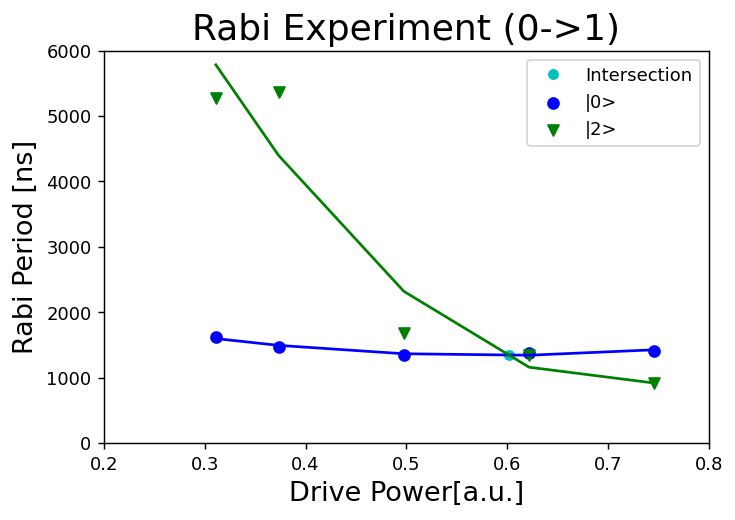

In [207]:
amp=abs(new_cx.instructions[0][1].pulse.amp)
x = []
for times in amp_list:
    x.append(amp*times)
    
x = x
y1 = freq0_list
y2 = freq2_list
fig, ax = plt.subplots(dpi=130)
model = PolynomialModel(degree=2)

params = model.guess(y1, x)
result = model.fit(y1, params=params, x=x)

params2 = model.guess(y2, x)
result2 = model.fit(y2, params=params2, x=x)

xc, yc = test.interpolated_intercept(x,np.array(result.best_fit),np.array(result2.best_fit))
plt.plot(xc, yc, 'co', ms=5, label='Intersection')
pure_amp_times = xc/amp
print("交点の座標は(Drive Power,Rabi Period)=(",xc,",",yc,")")
print("defaultのdrive powerに",pure_amp_times,"倍すればOK")

ax.scatter(x, y1, marker="o", color = "blue", label="|0>")
ax.scatter(x, y2, marker="v", color = "green", label="|2>")

plt.plot(x, result.best_fit, 'b-')
plt.plot(x, result2.best_fit, 'g-')

ax.set_xlim(0.2, 0.8)
ax.set_ylim(0, 6000)
plt.xlabel("Drive Power[a.u.]", fontsize=15)
plt.ylabel("Rabi Period [ns]", fontsize=15)
plt.title('Rabi Experiment (0->1)', fontsize=20)
plt.legend(loc='best')
plt.show()

制御ビットの状態が|1>の時の方が極値になるタイミングが早いようです。なのでRxの角度をを小さくしてCross ResonanceによるRabi振動のスタートをより|0>側に近づけます。

In [21]:
angle_list=[0, np.pi/5, np.pi/4, np.pi/3, np.pi/2]
rx_sweep0, rx_sweep1 = test.rx_sweep(angle_list, drive_durations, amp_times=pure_amp_times)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [25]:
def find_peak(rx_sweep0, rx_sweep1, drive_durations):
    duration_list0=[]
    duration_list1=[]
    for data in rx_sweep0:
        mini = np.min(np.real(data)[:round(len(data)/2)])
        index0 = list(np.real(data)).index(mini)
        duration_list0.append(drive_durations[index0])
    for data in rx_sweep1:
        maxi = np.max(np.real(data)[:round(len(data)/2)])
        index1 = list(np.real(data)).index(maxi)
        duration_list1.append(drive_durations[index1])
    return duration_list0, duration_list1

In [26]:
duration_list0, duration_list1 = find_peak(rx_sweep0, rx_sweep1, drive_durations)

交点の座標は(Rotation Angle of Rx Duration)=( 1.2028984284795277 , 206.05949146638793 )


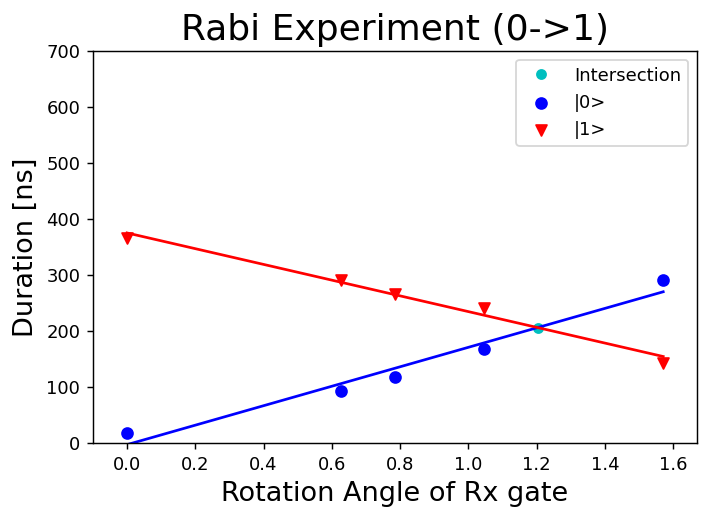

In [209]:
x = angle_list
y1 = test.dt_to_ns(duration_list0)
y2 = test.dt_to_ns(duration_list1)
fig, ax = plt.subplots(dpi=130)
model = PolynomialModel(degree=1)

params = model.guess(y1, x)
result = model.fit(y1, params=params, x=x)

params2 = model.guess(y2, x)
result2 = model.fit(y2, params=params2, x=x)

xc, yc = test.interpolated_intercept(x,np.array(result.best_fit),np.array(result2.best_fit))
plt.plot(xc, yc, 'co', ms=5, label='Intersection')
pure_angle = xc
pure_duration = yc
print("交点の座標は(Rotation Angle of Rx Duration)=(",xc,",",yc,")")

ax.scatter(x, y1, marker="o", color = "blue", label="|0>")
ax.scatter(x, y2, marker="v", color = "red", label="|1>")

plt.plot(x, result.best_fit, 'b-')
plt.plot(x, result2.best_fit, 'r-')

ax.set_xlim(-0.1, np.pi/2+0.1)
ax.set_ylim(0, 700)
plt.xlabel("Rotation Angle of Rx gate", fontsize=15)
plt.ylabel("Duration [ns]", fontsize=15)
plt.title('Rabi Experiment (0->1)', fontsize=20)
plt.legend(loc='best')
plt.show()

In [29]:
pure_amp_times, pure_angle, pure_duration

(1.9651415454403276, 1.2028984284795277, 206.05949146638793)

In [30]:
pure_cnot = test.pure_cnot(pure_amp_times, pure_angle, pure_duration)

実際にこれがCNOTになっているかベル状態を作ることで確認します。

In [31]:
qc_h = QuantumCircuit(1)
qc_h.h(0)
transpiled_qc_h = transpile(qc_h, backend, initial_layout = [ctr_q2])
sched_h = schedule(transpiled_qc_h, backend)

qc_meas = QuantumCircuit(2,2)
qc_meas.measure(0,0)
qc_meas.measure(1,1)
transpiled_qc_meas = transpile(qc_meas, backend, initial_layout = [ctr_q2,tar_q])
sched_meas2 = schedule(transpiled_qc_meas, backend)

In [32]:
entangle_sched = pulse.Schedule()
entangle_sched += sched_h
entangle_sched += pure_cnot << entangle_sched.duration
entangle_sched += sched_meas2 << entangle_sched.duration

entangle_sched2 = pulse.Schedule()
entangle_sched2 += sched_h
entangle_sched2 += sched_cx01
entangle_sched2 += sched_meas2 << entangle_sched.duration

In [33]:
entangle_expt_program = assemble([entangle_sched,entangle_sched2], backend=backend, meas_level=2, meas_return='avg', shots=8192)
IQ_entangle_job = backend.run(entangle_expt_program)
job_monitor(IQ_entangle_job)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job has successfully run


In [34]:
meas_calibs, state_labels = complete_meas_cal(qubit_list=[ctr_q2,tar_q], circlabel='mcal')
        
job0 = execute(meas_calibs, backend=backend, shots=8192)
job_monitor(job0)
cal_results = job0.result()

Job Status: job has successfully run


In [35]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=[ctr_q2,tar_q], circlabel='mcal')
meas_filter = meas_fitter.filter

results0 = IQ_entangle_job.result()
counts0 = results0.get_counts()
sim_sum0 = {'00': 4096, '11': 4096}

mitigated_results_raw = meas_filter.apply(results0)
mitigated_counts_raw0 = mitigated_results_raw.get_counts(0)
mitigated_counts_raw1 = mitigated_results_raw.get_counts(1)

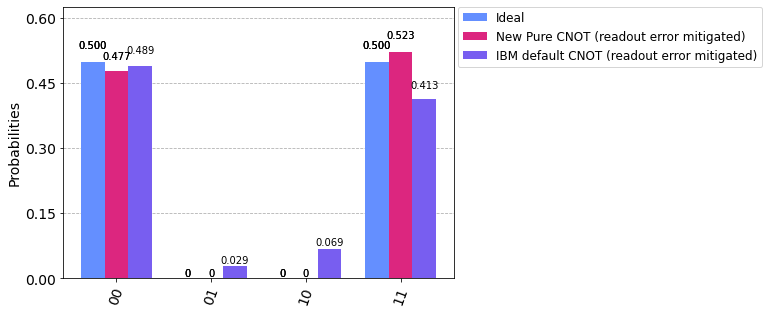

In [36]:
counts = [sim_sum0,mitigated_counts_raw0,mitigated_counts_raw1]
legend = ['Ideal', 'New Pure CNOT (readout error mitigated)','IBM default CNOT (readout error mitigated)']
plot_histogram(counts,number_to_keep=None,legend=legend)

In [37]:
import math
def fidelity(count1,count2,shots):
    fidelity=0
    for key1,value1 in count1.items():
        for key2,value2 in count2.items():
            if key1 == key2:
                fidelity+=math.sqrt((value1*value2))/shots
    return fidelity

def all_fidelities(sim_counts, counts_list, shots):
    fidelity_list = []
    for counts in counts_list:
        each_fidelity = fidelity(sim_counts, counts ,shots)
        fidelity_list.append(each_fidelity)
    return fidelity_list

In [38]:
sum_list_const = [mitigated_counts_raw0,mitigated_counts_raw1]
fidelities_const = all_fidelities(sim_sum0, sum_list_const, shots=8192)
print(fidelities_const)

[0.9997466247500022, 0.9492039822123112]


### 前日にCalibrationした値を用いる場合

In [14]:
pure_amp_times = 0.8740767094225959
pure_angle     = 0.890117918517109
pure_duration  = 356.26666666666694

In [15]:
pure_cnot = test.pure_cnot(pure_amp_times, pure_angle, pure_duration)

## 4. Pulse Schedule <a id="d"></a>

これでQutrit上でToffoliを構成するためのゲートが全て揃ったので、それをPulse Schedule上で順番に並べていきます。

In [39]:
qc_cx12 = QuantumCircuit(2)
qc_cx12.cx(0,1)
transpiled_qc_cx12 = transpile(qc_cx12, backend, initial_layout = [ctr_q1, ctr_q2])
sched_cx12 = schedule(transpiled_qc_cx12, backend)

qc_measure = QuantumCircuit(3,3)
qc_measure.measure(0,0)
qc_measure.measure(1,1)
qc_measure.measure(2,2)
transpiled_qc_measure = transpile(qc_measure, backend, initial_layout = [ctr_q1,ctr_q2,tar_q])
pulse_schedule_measure = schedule(transpiled_qc_measure, backend)

In [59]:
qutrit_toffoli_sched = pulse.Schedule()
qutrit_toffoli_sched += test.sched_x
qutrit_toffoli_sched += pulse.Play(test.pi_pulse_12, DriveChannel(ctr_q2))
qutrit_toffoli_sched += sched_cx12
qutrit_toffoli_sched += pure_cnot << qutrit_toffoli_sched.duration
qutrit_toffoli_sched = qutrit_toffoli_sched.insert(qutrit_toffoli_sched.duration,sched_cx12)
qutrit_toffoli_sched += pulse.Play(test.pi_pulse_12_reverse, DriveChannel(ctr_q2))
qutrit_toffoli_sched += test.sched_x

## 5. New Toffoli on Qutrits vs Old Toffoli on Qubits <a id="e"></a>

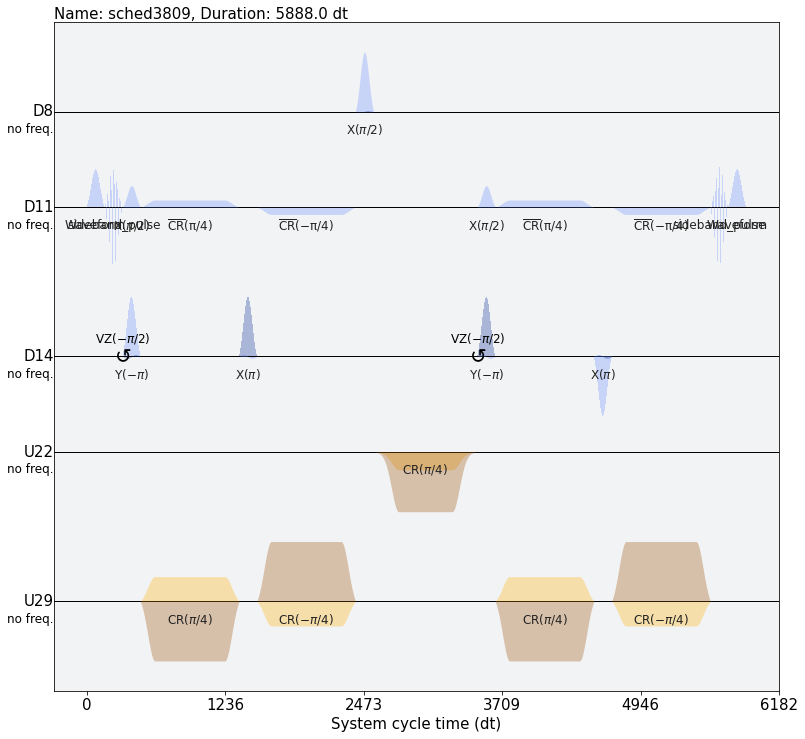

In [60]:
qutrit_toffoli_sched.draw()

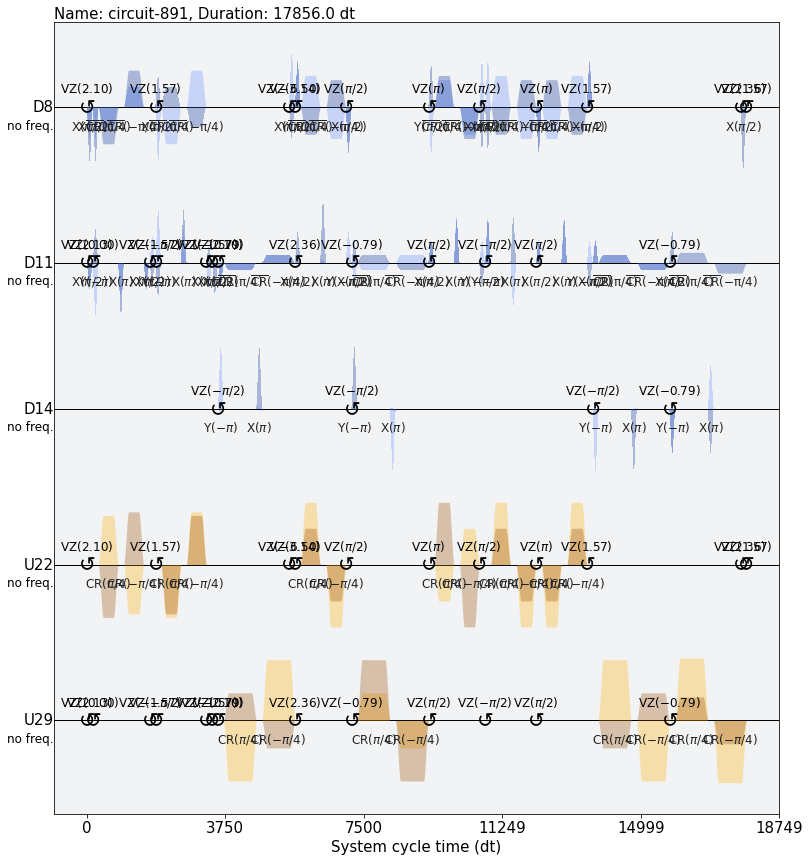

In [63]:
qc_old_toffoli = QuantumCircuit(3,3)
qc_old_toffoli.ccx(0,1,2)
transpiled_qc_old_toffoli = transpile(qc_old_toffoli, backend, initial_layout = [ctr_q1,ctr_q2,tar_q], optimization_level=3)
pulse_schedule_old_toffoli = schedule(transpiled_qc_old_toffoli, backend)
pulse_schedule_old_toffoli.draw()

分解の形だけをみればCNOTの数が半分になるので大体2倍の時間短縮を予想していましたが、実際は3倍以上の時間短縮に成功していることがわかります。これは限られたtopology上でtoffoliを分解しているのでswapもさらに加わっており、当初の予想より優位性が高まることを示唆しています。ちなみに制御ビット数が増えるほどQutrit上の分解手法の優位性がCNOTの数の面でもSWAP数の面でもどんどん高まるので、toffoliの時点でこれだけ優位性があることは嬉しいことです。後はいかに$X_{12}$ gateのerror rateを下げるかがキーポイントになってきます。

では実際に2つのtoffoli gateを実機で動かし測定した結果を見てみたいと思います。初期状態は|000>とします。それぞれの初期状態の場合に測定される結果も|000>に近いと嬉しいです。ちなみになぜ|000>で試しているかというと、$X_{12}$ gateが失敗（何も作用していない）した場合に出力に変化があるのがこの初期状態だからです。失敗していると|001>になります（これは回路図から2つの$X_{12}$ gateを取り除いたらわかります）。

In [64]:
qutrit_toffoli_sched += pulse_schedule_measure << qutrit_toffoli_sched.duration # 駆動パルスの後に測定をシフト
pulse_schedule_old_toffoli += pulse_schedule_measure << pulse_schedule_old_toffoli.duration # 駆動パルスの後に測定をシフト

In [65]:
toffoli_expt_program = assemble([qutrit_toffoli_sched,pulse_schedule_old_toffoli],
                                backend=backend,
                                meas_level=2,
                                meas_return='avg',
                                shots=8192)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:436: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


In [66]:
IQ_toffoli_job1 = backend.run(toffoli_expt_program)
print(IQ_toffoli_job1.job_id())
job_monitor(IQ_toffoli_job1)

613f622610b4a2770ca0d831
Job Status: job has successfully run


In [67]:
meas_calibs, state_labels = complete_meas_cal(qubit_list=[ctr_q1,ctr_q2,tar_q], circlabel='mcal')
        
job1 = execute(meas_calibs, backend=backend, shots=8192)
job_monitor(job1)
cal_results = job1.result()

Job Status: job has successfully run


In [68]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=[ctr_q1,ctr_q2,tar_q], circlabel='mcal')
meas_filter = meas_fitter.filter

results1 = IQ_toffoli_job1.result()
counts1 = results1.get_counts()
sim_sum1={'000': 8192}

mitigated_results_raw = meas_filter.apply(results1)
mitigated_counts_raw0_2 = mitigated_results_raw.get_counts(0)
mitigated_counts_raw1_2 = mitigated_results_raw.get_counts(1)

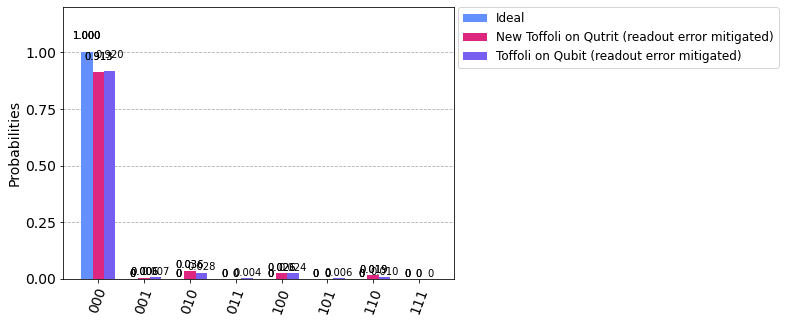

In [69]:
counts = [sim_sum1,mitigated_counts_raw0_2,mitigated_counts_raw1_2]
legend = ['Ideal', 'New Toffoli on Qutrit (readout error mitigated)','Toffoli on Qubit (readout error mitigated)']
plot_histogram(counts,number_to_keep=None,legend=legend)

In [70]:
sum_list_const = [mitigated_counts_raw0_2,mitigated_counts_raw1_2]
fidelities_const = all_fidelities(sim_sum1, sum_list_const, shots=8192)
print(fidelities_const)

[0.9553160157386699, 0.9593578012204669]


赤のヒストグラムがqubit上のtoffoli gateで、青のヒストグラムではQutrit上での新しいtoffoliです。若干|010>と|110>が見えているのはおそらくX12 gateの限界から来ているものです。Pure CNOTはきちんと機能していることがわかります。
<br>
<br>
次にtoffoliの作用をチェックします。二つの制御ビットのアダマールゲートをかけて制御ビットが|11>の時だけ反転し|111>になっているか確認します。

In [71]:
qc_hh = QuantumCircuit(2)
qc_hh.h(0)
qc_hh.h(1)
transpiled_qc_hh = transpile(qc_hh, backend, initial_layout = [ctr_q1,ctr_q2])
sched_hh = schedule(transpiled_qc_hh, backend)

In [72]:
toffoli_check_new = pulse.Schedule()
toffoli_check_new += sched_hh
toffoli_check_new += qutrit_toffoli_sched << sched_hh.duration

In [73]:
toffoli_check_old = pulse.Schedule()
toffoli_check_old += sched_hh
toffoli_check_old += pulse_schedule_old_toffoli << sched_hh.duration

In [74]:
toffoli_expt_program = assemble([toffoli_check_new,toffoli_check_old],
                                backend=backend,
                                meas_level=2,
                                meas_return='avg',
                                shots=8192)

In [75]:
IQ_toffoli_job2 = backend.run(toffoli_expt_program)
print(IQ_toffoli_job2.job_id())
job_monitor(IQ_toffoli_job2)

613f6287f020e872af6b9cc8
Job Status: job has successfully run


In [76]:
results2 = IQ_toffoli_job2.result() 
counts2 = results2.get_counts()
sim_sum2={'000': 2048,'001': 2048,'010': 2048,'111': 2048}

mitigated_results_raw = meas_filter.apply(results2)
mitigated_counts_raw0_3 = mitigated_results_raw.get_counts(0)
mitigated_counts_raw1_3 = mitigated_results_raw.get_counts(1)

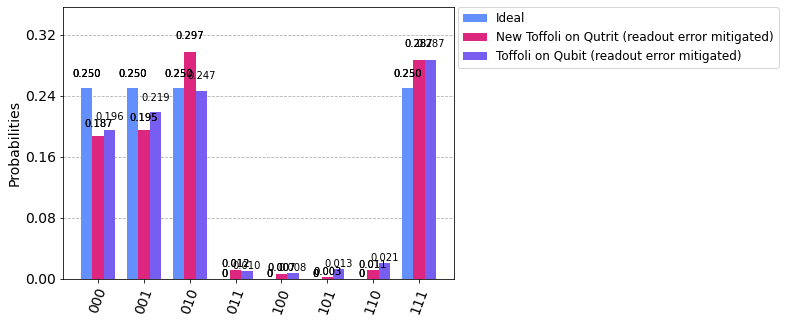

In [77]:
counts = [sim_sum2,mitigated_counts_raw0_3,mitigated_counts_raw1_3]
legend = ['Ideal', 'New Toffoli on Qutrit (readout error mitigated)','Toffoli on Qubit (readout error mitigated)']
plot_histogram(counts,number_to_keep=None,legend=legend)

In [78]:
sum_list_const = [mitigated_counts_raw0_3,mitigated_counts_raw1_3]
fidelities_const = all_fidelities(sim_sum2, sum_list_const, shots=8192)
print(fidelities_const)

[0.9774687817081817, 0.9711980903653994]


classical fidelityで比較すると新しいtoffoliの方が近い作用をしていることが確認できます。ただ本物の|001>がすくなくいらない|110>が多いのはこれも2つ目のqubitにかかっているX12 gateの限界です。最後にQutritはstayできる時間が短いのが難点です。そのためtoffoliをたくさん並べてどの時間まで優位性が保てるかを測ってみます。

In [79]:
qutrit_toffoli_sched = qutrit_toffoli_sched.exclude(
    channels=[pulse.MeasureChannel(ctr_q1),pulse.MeasureChannel(ctr_q2),pulse.MeasureChannel(tar_q),
              pulse.AcquireChannel(ctr_q1),pulse.AcquireChannel(ctr_q2),pulse.AcquireChannel(tar_q)])
pulse_schedule_old_toffoli = pulse_schedule_old_toffoli.exclude(
    channels=[pulse.MeasureChannel(ctr_q1),pulse.MeasureChannel(ctr_q2),pulse.MeasureChannel(tar_q),
              pulse.AcquireChannel(ctr_q1),pulse.AcquireChannel(ctr_q2),pulse.AcquireChannel(tar_q)])

In [80]:
def toffoli_length_new(list1):
    sched_list=[]
    for times in list1:
        toffoli_check_new = pulse.Schedule()
        toffoli_check_new += sched_hh
        for _ in range(times):
            toffoli_check_new = toffoli_check_new.insert(toffoli_check_new.duration,qutrit_toffoli_sched)
        toffoli_check_new += pulse_schedule_measure << toffoli_check_new.duration # 駆動パルスの後に測定をシフト
        sched_list.append(toffoli_check_new)

    toffoli_expt_program = assemble(sched_list,backend=backend,meas_level=2,meas_return='avg',shots=8192)
    IQ_toffoli_job = backend.run(toffoli_expt_program)
    job_monitor(IQ_toffoli_job)

    results = IQ_toffoli_job.result() 
    counts = results.get_counts()
    mitigated_results_raw = meas_filter.apply(results)
    
    counts_list=[]
    for x in range(len(list1)):
        mitigated_counts_raw = mitigated_results_raw.get_counts(x)
        counts_list.append(mitigated_counts_raw)
        
    fidelities_const = all_fidelities(sim_sum2, counts_list, shots=8192)

    return fidelities_const

def toffoli_length_old(list1):
    sched_list=[]
    for times in list1:
        toffoli_check_old = pulse.Schedule()
        toffoli_check_old += sched_hh
        for _ in range(times):
            toffoli_check_old = toffoli_check_old.insert(toffoli_check_old.duration,pulse_schedule_old_toffoli)
        toffoli_check_old += pulse_schedule_measure << toffoli_check_old.duration # 駆動パルスの後に測定をシフト
        sched_list.append(toffoli_check_old)

    toffoli_expt_program = assemble(sched_list,backend=backend,meas_level=2,meas_return='avg',shots=8192)
    IQ_toffoli_job = backend.run(toffoli_expt_program)
    job_monitor(IQ_toffoli_job)

    results = IQ_toffoli_job.result() 
    counts = results.get_counts()
    mitigated_results_raw = meas_filter.apply(results)
    
    counts_list=[]
    for x in range(len(list1)):
        mitigated_counts_raw = mitigated_results_raw.get_counts(x)
        counts_list.append(mitigated_counts_raw)
        
    fidelities_const = all_fidelities(sim_sum2, counts_list, shots=8192)

    return fidelities_const

In [81]:
list1=[]
for x in range(100):
    if x%4 == 1:
        list1.append(x)

In [82]:
fid_new = toffoli_length_new(list1)

Job Status: job has successfully run


In [83]:
fid_old = toffoli_length_old(list1)

Job Status: job has successfully run


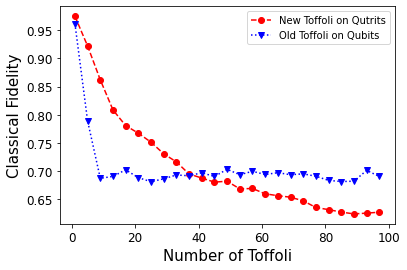

In [84]:
x = list1
y1 = fid_new
y2 = fid_old

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y1, marker="o", color = "red", linestyle = "--", label="New Toffoli on Qutrits")
ax.plot(x, y2, marker="v", color = "blue", linestyle = ":", label="Old Toffoli on Qubits")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Number of Toffoli",fontsize=15)
plt.ylabel("Classical Fidelity",fontsize=15)

ax.legend()

0.7付近で足止めになっている理由はclassical fidelityで評価できる限界で、完全にノイズにさらされると測定されうるすべてのビット列のcount数が下に書いてあるように等しくなります。その時のclassical fidelityが0.7です。（3 qubitの測定の場合）

In [85]:
all_fidelities(sim_sum2, [{'000': 1024,'001': 1024,'010': 1024,'011': 1024,'100': 1024,'101': 1024,'110': 1024,'111': 1024}], shots=8192)

[0.7071067811865476]

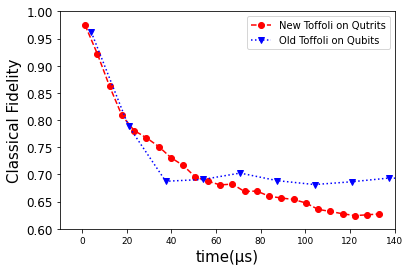

In [194]:
#x1 = np.array(list1)*qutrit_toffoli_sched.duration
#x2 = np.array(list1)*qc_old_toffoli.duration
x1 = np.array(list1)*6182 *0.222222222222*1e-3 #(μs)
x2 = np.array(list1)*18749*0.222222222222*1e-3 #(μs)

y1 = fid_new
y2 = fid_old

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x1, y1, marker="o", color = "red", linestyle = "--", label="New Toffoli on Qutrits")
ax.plot(x2, y2, marker="v", color = "blue", linestyle = ":", label="Old Toffoli on Qubits")
ax.set_xlim(-10, 140)
ax.set_ylim(0.6, 1)
plt.xticks(fontsize=9)
plt.yticks(fontsize=12)
plt.xlabel("time(μs)",fontsize=15)
plt.ylabel("Classical Fidelity",fontsize=15)

ax.legend()

20μsまでは完全に時間依存であることから、この時まではdepolarizing errorが効いていると予想できます。しかし途中かNew Toffoliの方が謎の挙動を示し始めます。完全にdepolarizing errorにさらされた場合はOld ToffoliのようにClassical Fidelity=0.7で収束するはずですが、それ以下まで沈んでいることは別のエラーがはいっている可能性を示しています。

In [95]:
def toffoli_length_new_99():
    sched_list=[]
    toffoli_check_new = pulse.Schedule()
    toffoli_check_new += sched_hh
    for _ in range(99):
        toffoli_check_new = toffoli_check_new.insert(toffoli_check_new.duration,qutrit_toffoli_sched)
    toffoli_check_new += pulse_schedule_measure << toffoli_check_new.duration # 駆動パルスの後に測定をシフト
    sched_list.append(toffoli_check_new)

    toffoli_expt_program = assemble(sched_list,backend=backend,meas_level=2,meas_return='avg',shots=8192)
    IQ_toffoli_job = backend.run(toffoli_expt_program)
    job_monitor(IQ_toffoli_job)

    results = IQ_toffoli_job.result() 
    counts = results.get_counts()
    mitigated_results_raw = meas_filter.apply(results)
    
    counts_list=[]
    mitigated_counts_raw = mitigated_results_raw.get_counts(0)
    counts_list.append(mitigated_counts_raw)

    fidelities_const = all_fidelities(sim_sum2, counts_list, shots=8192)

    return mitigated_counts_raw,fidelities_const

In [96]:
mitigated_counts_raw,fidelities_const=toffoli_length_new_99()

Job Status: job has successfully run


In [100]:
fidelities_const

[0.6645650502477143]

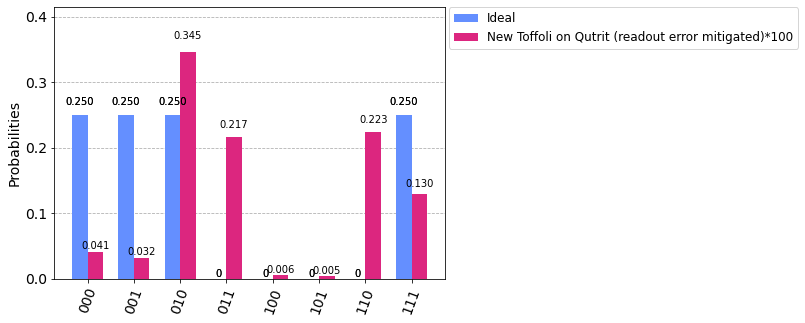

In [98]:
counts = [sim_sum2,mitigated_counts_raw]
legend = ['Ideal', 'New Toffoli on Qutrit (readout error mitigated)*100']
plot_histogram(counts,number_to_keep=None,legend=legend)

Qutritとして扱っている量子ビットがほぼ全て|1>になってしまっていることがわかります。depolarzing errorによって|0>と|1>が均等に別れているわけではなく、もう少し特殊な状況になっています。

In [148]:
test = x12.sweep(qubit=ctr_q2, shots=8192, backend=backend, scale_factor=1e-7,
                 x01_freq=x01_freq_real, x01_amp=x01_amp_real)

In [153]:
def toffoli_length_new_99_meas1():
    sched_list=[]
    toffoli_check_new = pulse.Schedule()
    toffoli_check_new += sched_hh
    for _ in range(99):
        toffoli_check_new = toffoli_check_new.insert(toffoli_check_new.duration,qutrit_toffoli_sched)
    toffoli_check_new += test.sched_meas << toffoli_check_new.duration # 駆動パルスの後に測定をシフト
    sched_list.append(toffoli_check_new)

    toffoli_expt_program = assemble(sched_list,backend=backend,meas_level=1,meas_return='single',shots=8192)
    IQ_toffoli_job = backend.run(toffoli_expt_program)
    job_monitor(IQ_toffoli_job)

    return IQ_toffoli_job

In [154]:
IQ_toffoli_job=toffoli_length_new_99_meas1()

Job Status: job has successfully run


Text(0.5, 1.0, '0-1-2 discrimination')

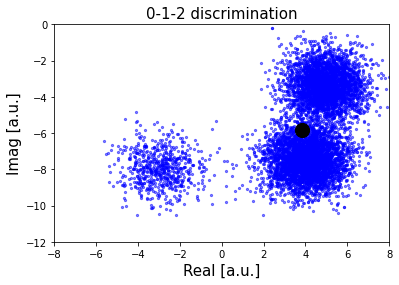

In [162]:
IQ_toffoli_data = test.get_job_data(IQ_toffoli_job, average=False)

(x_min,x_max,y_min,y_max)=(-8,8,-12,0)

plt.scatter(np.real(IQ_toffoli_data), np.imag(IQ_toffoli_data),s=5, cmap='viridis', c='blue', alpha=0.5)
mean_zero = np.mean(IQ_toffoli_data)
plt.scatter(np.real(mean_zero), np.imag(mean_zero),s=200, cmap='viridis', c='black',alpha=1.0)

plt.xlim(x_min, x_max)
plt.ylim(y_min,y_max)
plt.ylabel('Imag [a.u.]', fontsize=15)
plt.xlabel('Real [a.u.]', fontsize=15)
plt.title("0-1-2 discrimination", fontsize=15)

Qutritとして扱っている量子ビットを測定した結果をみると、|1>と|2>のstateばかりに集中していることがわかります。原因は
<br>
・最初のX12 gateによって励起された|2>はCNOT3つの間に脱励起によって|1>や|0>が増えます。そのノイズ分は２回目ののX12 gateを作用させると|0>と|2>が増えるということになります。これは最後のX01 gateで|1>と|2>が増えるということになります。これを繰り返すことで|1>と|2>ばかりが残るという仕組みを説明できます。
<br>
・他にはX12 gateのCalibration error（特にamplitudeの方で回転角の若干のずれが影響している？z回転が影響？そういう意味では量子エラー？）もあるかもしれません。
<br>
<br>
Toffoli on Qutritもdepolarizing errorに関してはToffoli on Qubitと非常に似た挙動を示すことから、もし脱励起の問題を解決できればToffoli on Qubitと同じ40μs付近までは寿命を伸ばせると考えられます。例えば脱励起時間自体を減らす、つまり|2>のstateにstayしている時間を減らすという意味で他の分解方法を試すなどが考えられます。